In [1]:
import pandas as pd
import numpy as np

In [2]:
census_tracts = pd.read_csv('../data/processed/census_tracts_per_checkin.csv')
checkin_dataset = pd.read_csv('../data/raw/foursquare-nyc-check-ins/dataset_TSMC2014_NYC.csv')
checkin_dataset['censusTract'] = census_tracts['census_tract']

In [3]:
labels_path = '../data/raw/new-york-city-census-data/'
demographics = pd.read_csv(labels_path + 'nyc_census_tracts.csv')
print ('total census tracts:', len(demographics))
demographics = demographics[demographics['Income'].notnull()]
print ('excluded null:', len(demographics))

examples = pd.DataFrame()
examples['census_tract'] = demographics['CensusTract']


total census tracts: 2167
excluded null: 2101


###### examples = pd.DataFrame()
examples['census_tract'] = demographics['CensusTract']
 # debug
# helper function to strip all non-alphanumericc characters to form feature keys
import re
def keyify_string(s):
    return re.sub('[^0-9a-zA-Z]+', '_', s).lower()

In [4]:
#calculate total number of checkins per census tract

def get_num_checkins_key():
        return 'num_checkins'

def add_num_checkins(checkins, idx):    
    examples.loc[idx, get_num_checkins_key()] = len(checkins)

In [5]:
%%time 

import sys

no_checkins = 0
total_checkins = 0
for idx, d in examples['census_tract'].iteritems():
    # show progress 
    sys.stdout.write('\r' + str(idx+1) + ' / ' + str(len(examples)) + ' examples processed')
    sys.stdout.flush()
    
    # compute all checkins in current census tract
    checkins_in_census_tract = checkin_dataset[checkin_dataset['censusTract'] == d]
    
    # compute metadata
    total_checkins += len(checkins_in_census_tract)
    if len(checkins_in_census_tract) == 0: 
        no_checkins += 1
    
    # add features
    add_num_checkins(checkins_in_census_tract, idx)

2166 / 2101 examples processedWall time: 12.6 s


In [6]:
print ('no checkin data associated with # businesses:', no_checkins)
print (total_checkins)

no checkin data associated with # businesses: 220
174417


In [7]:
df= pd.merge(examples, demographics, left_index=True, right_index=True)
filt_df = df.loc[:, df.columns != 'CensusTract']
filter_df=filt_df.loc[:, filt_df.columns != 'census_tract']
df=filter_df.drop(['County','Borough'], axis=1)
P = np.percentile(df.num_checkins, [5, 95])
data_clean = df[(df.num_checkins > P[0]) & (df.num_checkins < P[1])]
null_data = data_clean[data_clean.isnull().any(axis=1)]
data_clean=data_clean.dropna()

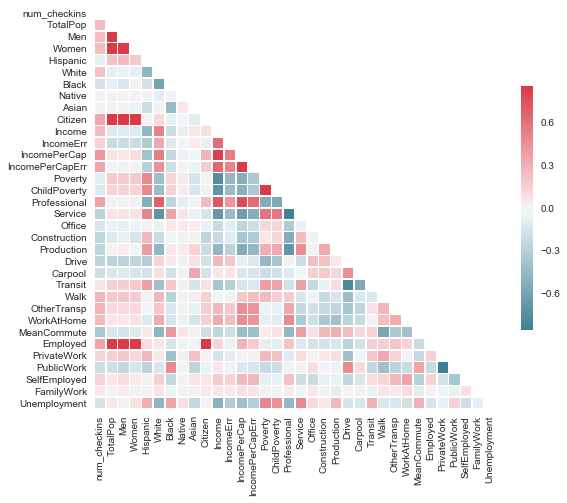

In [9]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(style="white")
corr = data_clean.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns_plot=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig = sns_plot.get_figure()
fig.savefig("Figure1.png")

In [10]:
correlation = data_clean.corr()
writer = pd.ExcelWriter("corr.xlsx", engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
correlation.to_excel(writer, sheet_name='Sheet1')

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

# Add some cell formats.
format1 = workbook.add_format({'num_format': '#,##0.00'})
format2 = workbook.add_format({'num_format': '0%'})
# Set the column width and format.
worksheet.set_column('B:B', 18, format1)

# Set the format but not the column width.
worksheet.set_column('C:C', None, format2)

# Close the Pandas Excel writer and output the Excel file.
writer.save()


In [11]:
X = data_clean.as_matrix()[:, [1,4,5,6,8,9,10,14,18,19,20,21,22,24,25,26,28,31,32]].astype(int) # take all cols after first 
y = data_clean['num_checkins'].as_matrix()

In [12]:
from sklearn import preprocessing
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
X_norm = min_max_scaler.fit_transform(X)

C:\Users\Balan Gnanam\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [13]:
from sklearn.model_selection import train_test_split

NUM_FOLDS = 10
test_size = 1.0/(NUM_FOLDS)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=test_size)

In [14]:
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split

def cross_validate(model, X, y, folds=5):
    (M, n) = X.shape
    kf = KFold(M, n_folds=folds) # Define the split (5 folds)kf:
    
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf:
#         print '**fold**'
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = model.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        train_acc = np.sqrt(((y_train_pred - y_train) ** 2).mean())
        train_accuracies.append(train_acc)
#         print 'train acc:', train_acc
        
        test_acc = np.sqrt(((y_test_pred - y_test) ** 2).mean())
        test_accuracies.append(test_acc)
#         print 'test acc:', test_acc

    mean_train = np.mean(train_accuracies)
    mean_test = np.mean(test_accuracies)
    return (mean_train, mean_test)

def final_eval(model, X, y):
    clf = model.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    final_test_acc = np.sqrt(((y_test_pred - y_test) ** 2).mean())
    
    #return y_test_pred
    return final_test_acc

C:\Users\Balan Gnanam\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import random
random.seed(126)

models = {
    'svr': SVR(),
    'linear_svr': LinearSVR(),
    'gb': GradientBoostingRegressor(),
    'ada': AdaBoostRegressor(),
    'sgd': SGDRegressor(),
    'lr': LinearRegression(),
    'las':Lasso(alpha=0.1),
    'enet':ElasticNet(alpha=0.1, l1_ratio=0.7),
    
    
}

cols = ['model', 'train', 'cross-val', 'final']
results = pd.DataFrame(np.zeros((len(models), len(cols))), columns=cols)
results.head()
for idx, (mk, mv) in enumerate(models.items()):
    print ('processing:', mk)

    mean_train, mean_test = cross_validate(mv, X_train, y_train, folds=NUM_FOLDS)
    results.iloc[idx, 0] = mk
    results.iloc[idx, 1] = mean_train
    results.iloc[idx, 2] = mean_test
#     results.iloc[idx, 3] = np.nan
    results.iloc[idx, 3] = final_eval(mv, X_test, y_test)

# output_table
results


writer = pd.ExcelWriter("Table1.xlsx", engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
results.to_excel(writer, sheet_name='Sheet1')

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

# Add some cell formats.
format1 = workbook.add_format({'num_format': '#,##0.00'})
format2 = workbook.add_format({'num_format': '0%'})
# Set the column width and format.
worksheet.set_column('B:B', 18, format1)

# Set the format but not the column width.
worksheet.set_column('C:C', None, format2)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

processing: svr
processing: linear_svr
processing: gb
processing: ada
processing: sgd
processing: lr
processing: las
processing: enet


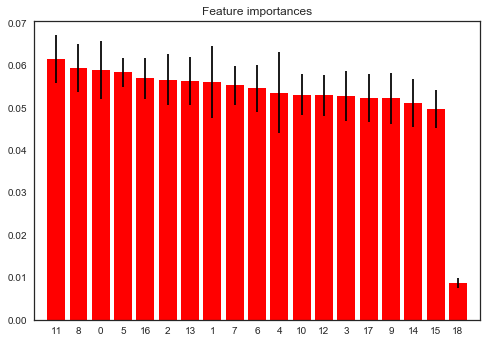

In [16]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier


# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X, y)
# display the relative importance of each attribute
importances=model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])

plt.savefig("feature.png")
plt.show()


In [17]:
cols = [2,32]
X1=np.delete(X,18,1)


model.fit(X1, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.0574135  0.05500508 0.06150086 0.05300175 0.05814735 0.05832381
 0.05940371 0.05487106 0.05499587 0.05521611 0.05777487 0.0594497
 0.05479601 0.05418913 0.04271197 0.05293332 0.05602819 0.05423772]


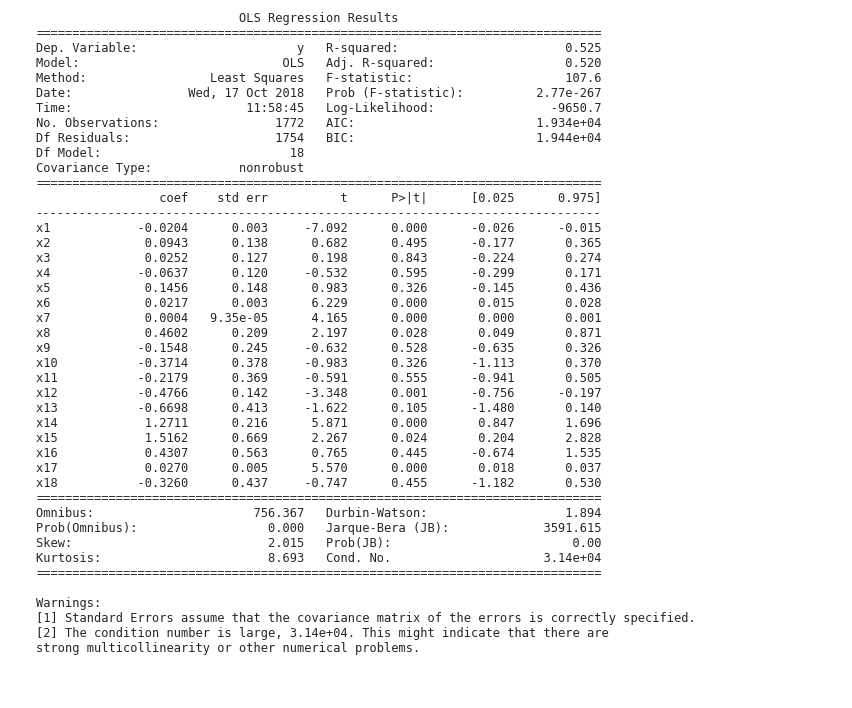

In [18]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

est = sm.OLS(y, X1)
est2 = est.fit()

plt.rc('figure', figsize=(12, 10))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(est2.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('Regression.png')

In [19]:
X2=X1[:, [0,5,6,7,11,13,14,16]]
est3 = sm.OLS(y, X2)
est4 = est3.fit()
print(est4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     240.3
Date:                Wed, 17 Oct 2018   Prob (F-statistic):          8.09e-276
Time:                        11:58:56   Log-Likelihood:                -9656.6
No. Observations:                1772   AIC:                         1.933e+04
Df Residuals:                    1764   BIC:                         1.937e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0211      0.003     -7.744      0.0

In [20]:
from sklearn import preprocessing
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
X_norm1 = min_max_scaler.fit_transform(X1)

C:\Users\Balan Gnanam\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [21]:
from sklearn.model_selection import train_test_split

NUM_FOLDS = 10
test_size = 1.0/(NUM_FOLDS)
X_train1, X_test1, y_train, y_test = train_test_split(X_norm1, y, test_size=test_size)

In [22]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import random
random.seed(129)

models = {
    'svr': SVR(),
    'linear_svr': LinearSVR(),
    'gb': GradientBoostingRegressor(),
    'ada': AdaBoostRegressor(),
    'sgd': SGDRegressor(),
    'lr': LinearRegression(),
    'las':Lasso(alpha=0.1),
    'enet':ElasticNet(alpha=0.1, l1_ratio=0.7),
    
    
}

cols = ['model', 'train', 'cross-val', 'final']
results = pd.DataFrame(np.zeros((len(models), len(cols))), columns=cols)
results.head()
for idx, (mk, mv) in enumerate(models.items()):
    print ('processing:', mk)

    mean_train, mean_test = cross_validate(mv, X_train1, y_train, folds=NUM_FOLDS)
    results.iloc[idx, 0] = mk
    results.iloc[idx, 1] = mean_train
    results.iloc[idx, 2] = mean_test
#     results.iloc[idx, 3] = np.nan
    results.iloc[idx, 3] = final_eval(mv, X_test1, y_test)

# output_table
results
writer = pd.ExcelWriter("Table2.xlsx", engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
results.to_excel(writer, sheet_name='Sheet1')

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

# Add some cell formats.
format1 = workbook.add_format({'num_format': '#,##0.00'})
format2 = workbook.add_format({'num_format': '0%'})
# Set the column width and format.
worksheet.set_column('B:B', 18, format1)

# Set the format but not the column width.
worksheet.set_column('C:C', None, format2)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

processing: svr
processing: linear_svr
processing: gb
processing: ada
processing: sgd
processing: lr
processing: las
processing: enet


In [23]:
from sklearn import preprocessing
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
X_norm2 = min_max_scaler.fit_transform(X2)

C:\Users\Balan Gnanam\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [24]:
NUM_FOLDS = 10
test_size = 1.0/(NUM_FOLDS)
X_train2, X_test2, y_train, y_test = train_test_split(X_norm2, y, test_size=test_size)

In [26]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import random
random.seed(129)

models = {
    'svr': SVR(),
    'linear_svr': LinearSVR(),
    'gb': GradientBoostingRegressor(),
    'ada': AdaBoostRegressor(),
    'sgd': SGDRegressor(),
    'lr': LinearRegression(),
    'las':Lasso(alpha=0.1),
    'enet':ElasticNet(alpha=0.1, l1_ratio=0.7),
    
    
}

cols = ['model', 'train', 'cross-val', 'final']
results = pd.DataFrame(np.zeros((len(models), len(cols))), columns=cols)
results.head()
for idx, (mk, mv) in enumerate(models.items()):
    print ('processing:', mk)

    mean_train, mean_test = cross_validate(mv, X_train2, y_train, folds=NUM_FOLDS)
    results.iloc[idx, 0] = mk
    results.iloc[idx, 1] = mean_train
    results.iloc[idx, 2] = mean_test
#     results.iloc[idx, 3] = np.nan
    results.iloc[idx, 3] = final_eval(mv, X_test2, y_test)

# output_table
results
writer = pd.ExcelWriter("Table4.xlsx", engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
results.to_excel(writer, sheet_name='Sheet1')

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

# Add some cell formats.
format1 = workbook.add_format({'num_format': '#,##0.00'})
format2 = workbook.add_format({'num_format': '0%'})
# Set the column width and format.
worksheet.set_column('B:B', 18, format1)

# Set the format but not the column width.
worksheet.set_column('C:C', None, format2)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

processing: svr
processing: linear_svr
processing: gb
processing: ada
processing: sgd
processing: lr
processing: las
processing: enet
